In [1]:
from pathlib import Path

DATA_DIR = Path(r"C:\Users\yang\Downloads\dataset-iiit-pet-master")  
IMAGES_DIR = DATA_DIR / "images"
ANN_DIR = DATA_DIR / "annotations"
TRIMAP_DIR = ANN_DIR / "trimaps"
LISTS_DIR = ANN_DIR / "list"
XML_DIR = ANN_DIR / "xmls"

# sanity check
for p in [IMAGES_DIR,ANN_DIR, TRIMAP_DIR, LISTS_DIR,XML_DIR]:
    print(p, "exists?", p.exists())

C:\Users\yang\Downloads\dataset-iiit-pet-master\images exists? True
C:\Users\yang\Downloads\dataset-iiit-pet-master\annotations exists? True
C:\Users\yang\Downloads\dataset-iiit-pet-master\annotations\trimaps exists? True
C:\Users\yang\Downloads\dataset-iiit-pet-master\annotations\list exists? False
C:\Users\yang\Downloads\dataset-iiit-pet-master\annotations\xmls exists? True


In [2]:
# Data Wrangling
import pandas as pd

def read_split_file(fp: Path) -> pd.DataFrame:
    df = pd.read_csv(fp, sep=r"\s+", header=None)
    if df.shape[1] >= 4:
        df = df.iloc[:, :4]
        df.columns = ["image_name", "class_id", "species_id", "breed_id"]
    elif df.shape[1] == 3:
        df.columns = ["image_name", "class_id", "species_id"]
        df["breed_id"] = pd.NA
    else:
        df.columns = [f"col_{i}" for i in range(df.shape[1])]
    return df

trainval_fp = ANN_DIR / "trainval.txt"
test_fp = ANN_DIR / "test.txt"

trainval_df = read_split_file(trainval_fp)
test_df = read_split_file(test_fp)

print("trainval:", trainval_df.shape, "test:", test_df.shape)
trainval_df.head()

trainval: (3680, 4) test: (3669, 4)


image_name  class_id  species_id  breed_id
0  Abyssinian_100         1           1         1
1  Abyssinian_101         1           1         1
2  Abyssinian_102         1           1         1
3  Abyssinian_103         1           1         1
4  Abyssinian_104         1           1         1

In [3]:
import numpy as np

def build_master_df(df: pd.DataFrame, split_name: str) -> pd.DataFrame:
    out = df.copy()
    out["split"] = split_name

    out["img_path"] = out["image_name"].apply(lambda x: str(IMAGES_DIR / f"{x}.jpg"))
    out["trimap_path"] = out["image_name"].apply(lambda x: str(TRIMAP_DIR / f"{x}.png"))
    out["xml_path"] = out["image_name"].apply(lambda x: str(XML_DIR / f"{x}.xml"))

    out["img_exists"] = out["img_path"].apply(lambda p: Path(p).exists())
    out["trimap_exists"] = out["trimap_path"].apply(lambda p: Path(p).exists())
    out["xml_exists"] = out["xml_path"].apply(lambda p: Path(p).exists())

    # breed name from file: Breed_### (Breed may contain underscores)
    out["breed_name"] = out["image_name"].apply(lambda s: "_".join(str(s).split("_")[:-1]))
    out["species_name"] = out.get("species_id", pd.Series([pd.NA]*len(out))).map({1: "cat", 2: "dog"}).fillna("unknown")

    return out

train_df = build_master_df(trainval_df, "trainval")
test_df2 = build_master_df(test_df, "test")

master_df = pd.concat([train_df, test_df2], ignore_index=True)

print("master:", master_df.shape)
print(master_df[["img_exists","trimap_exists","xml_exists"]].mean())
master_df.head()

master: (7349, 13)
img_exists       1.000000
trimap_exists    1.000000
xml_exists       0.499524
dtype: float64


image_name  class_id  species_id  breed_id     split  \
0  Abyssinian_100         1           1         1  trainval   
1  Abyssinian_101         1           1         1  trainval   
2  Abyssinian_102         1           1         1  trainval   
3  Abyssinian_103         1           1         1  trainval   
4  Abyssinian_104         1           1         1  trainval   

                                            img_path  \
0  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
1  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
2  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
3  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
4  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   

                                         trimap_path  \
0  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
1  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
2  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
3  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   
4  C:\Users\yang\Downloads\dataset-iiit-pet-maste...   

                                            xml_path  img_exists  \
0  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
1  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
2  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
3  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   
4  C:\Users\yang\Downloads\dataset-iiit-pet-maste...        True   

   trimap_exists  xml_exists  breed_name species_name  
0           True        True  Abyssinian          cat  
1           True        True  Abyssinian          cat  
2           True        True  Abyssinian          cat  
3           True        True  Abyssinian          cat  
4           True       False  Abyssinian          cat

In [4]:
#--------- check if test and trainval have any mix----------

train_names = set(master_df.loc[master_df["split"]=="trainval", "image_name"])
test_names  = set(master_df.loc[master_df["split"]=="test", "image_name"])
overlap = train_names & test_names
print("Train/Test overlap:", len(overlap))
if overlap:
    print("Example overlap:", list(overlap)[:10])

cov = (master_df.groupby(["split","breed_name"]).size()
              .unstack("split", fill_value=0))
print("Breeds missing in trainval:", (cov.get("trainval",0)==0).sum())
print("Breeds missing in test    :", (cov.get("test",0)==0).sum())

Train/Test overlap: 0
Breeds missing in trainval: 0
Breeds missing in test    : 0


In [5]:
eda_df = master_df.copy()
use_df = eda_df[eda_df["img_exists"]].copy()

print("Total rows:", len(eda_df))
print("Img exists ratio:", eda_df["img_exists"].mean())

Total rows: 7349
Img exists ratio: 1.0


In [6]:
missing_imgs = master_df.loc[~master_df["img_exists"], ["image_name","img_path"]]

print("Missing images:", len(missing_imgs))
print("Duplicate image_name:", master_df["image_name"].duplicated().sum())
print("Unique breeds:", master_df["breed_name"].nunique())
print("Species distribution:\n", master_df["species_name"].value_counts())


Missing images: 0
Duplicate image_name: 0
Unique breeds: 37
Species distribution:
 species_name
dog    4978
cat    2371
Name: count, dtype: int64


In [7]:
## Feature Engineering (Image Processing)
from PIL import Image

def safe_open_image(path: str) -> Image.Image:
    return Image.open(path).convert("RGB")

def edge_strength_simple(gray: np.ndarray) -> float:
    gx = np.abs(np.diff(gray.astype(np.float32), axis=1))
    gy = np.abs(np.diff(gray.astype(np.float32), axis=0))
    return float((gx.mean() + gy.mean()) / 2.0)

def compute_image_features(img_path: str) -> dict:
    img = safe_open_image(img_path)
    arr = np.array(img)  # H,W,3
    h, w = arr.shape[:2]
    #based on （ITU-R BT.601） Green 0.584  Red 0.2999 Blue 0.114
    gray = (0.299*arr[:, :, 0] + 0.587*arr[:, :, 1] + 0.114*arr[:, :, 2]).astype(np.float32)

    return {
        "width": int(w),
        "height": int(h),
        "aspect_ratio": float(w/h) if h else np.nan,
        "brightness": float(gray.mean()),
        "contrast": float(gray.std()),
        "r_mean": float(arr[:, :,0].mean()),
        "g_mean": float(arr[:, :,1].mean()),
        "b_mean": float(arr[:, :,2].mean()),
        "edge_strength": edge_strength_simple(gray),
    }



In [8]:
FEATURES_CACHE = DATA_DIR / "features_cache.csv"

REQUIRED_FEATURE_COLS = [
    "image_name",
    "width","height","aspect_ratio","brightness","contrast",
    "r_mean","g_mean","b_mean","edge_strength",
    "pet_area_ratio","unknown_ratio"
]

def build_features_with_cache(df: pd.DataFrame, cache_path: Path = FEATURES_CACHE) -> pd.DataFrame:
    # 1) 如果 cache 存在：先读，再检查列是否齐全
    if cache_path.exists():
        cached = pd.read_csv(cache_path)
        missing_cols = [c for c in REQUIRED_FEATURE_COLS if c not in cached.columns]
        if not missing_cols:
            return cached
        else:
            print(f"[Cache outdated] Missing columns in cache: {missing_cols}")
            print(f"Rebuilding cache: {cache_path}")
            cache_path.unlink()  # 删除旧 cache，强制重建

    # 2) 重建特征
    feats = []
    for _, row in df.iterrows():
        if not Path(row["img_path"]).exists():
            continue
        f_img = compute_image_features(row["img_path"])
        f_tri = compute_trimap_features(row["trimap_path"])
        feats.append({"image_name": row["image_name"], **f_img, **f_tri})

    out = pd.DataFrame(feats)

    # 3) 保底：确保必需列都在（没有的补 NaN）
    for c in REQUIRED_FEATURE_COLS:
        if c not in out.columns:
            out[c] = np.nan

    out.to_csv(cache_path, index=False)
    return out

feat_df = build_features_with_cache(master_df)
eda_df = master_df.merge(feat_df, on="image_name", how="left")

# 生成 use_df（用于 EDA / baseline）
use_df = eda_df[eda_df["img_exists"] & eda_df["trimap_exists"]].copy()


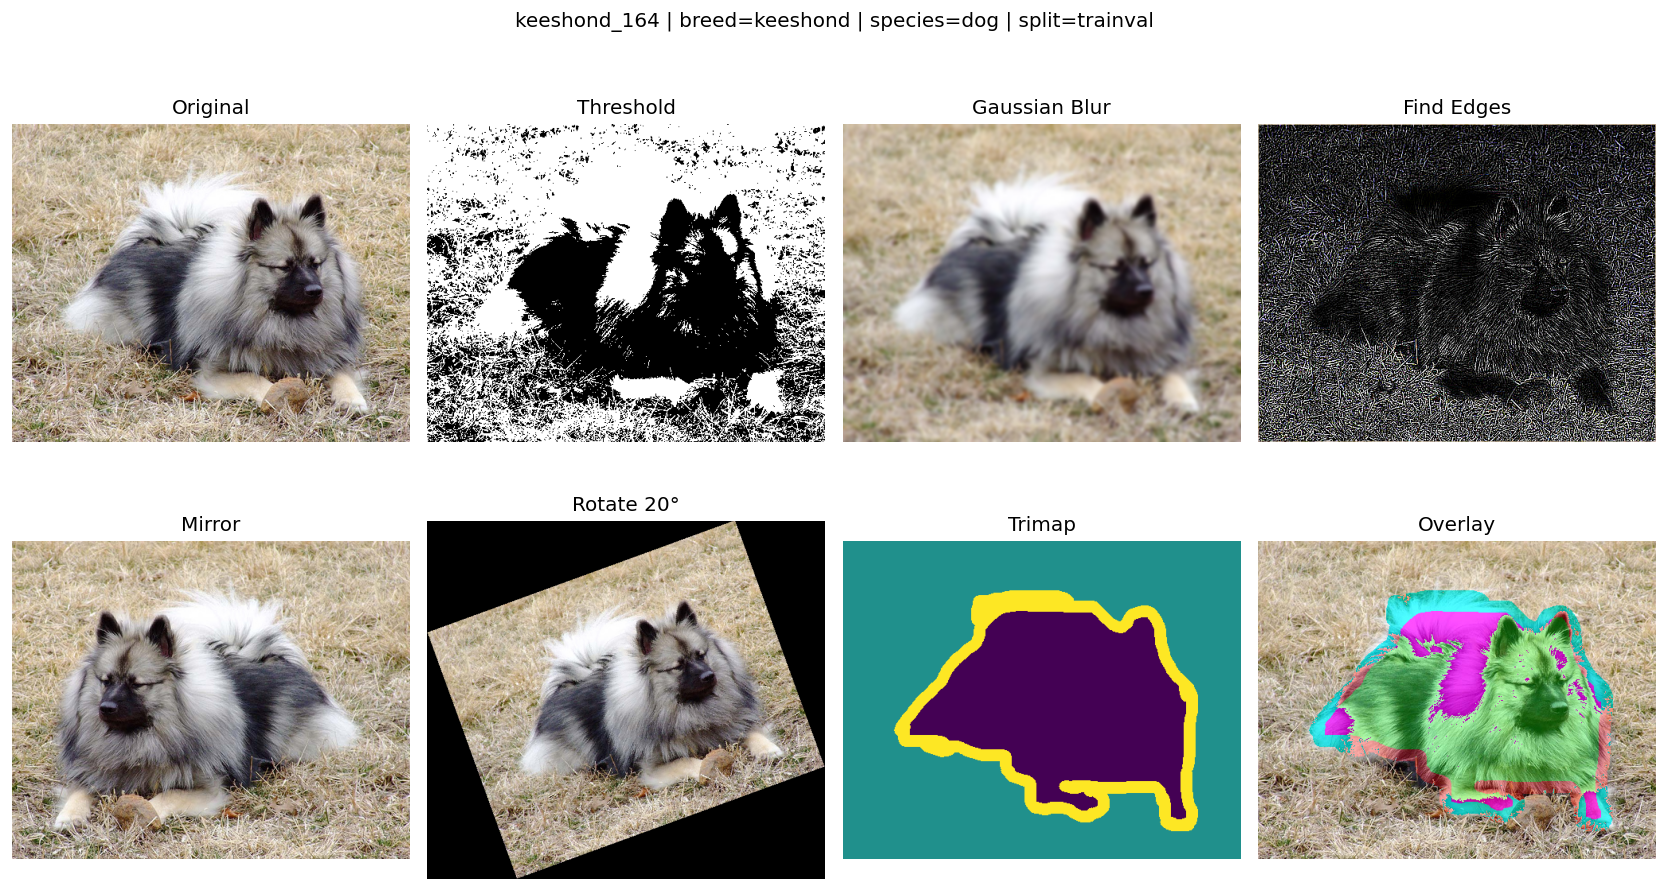

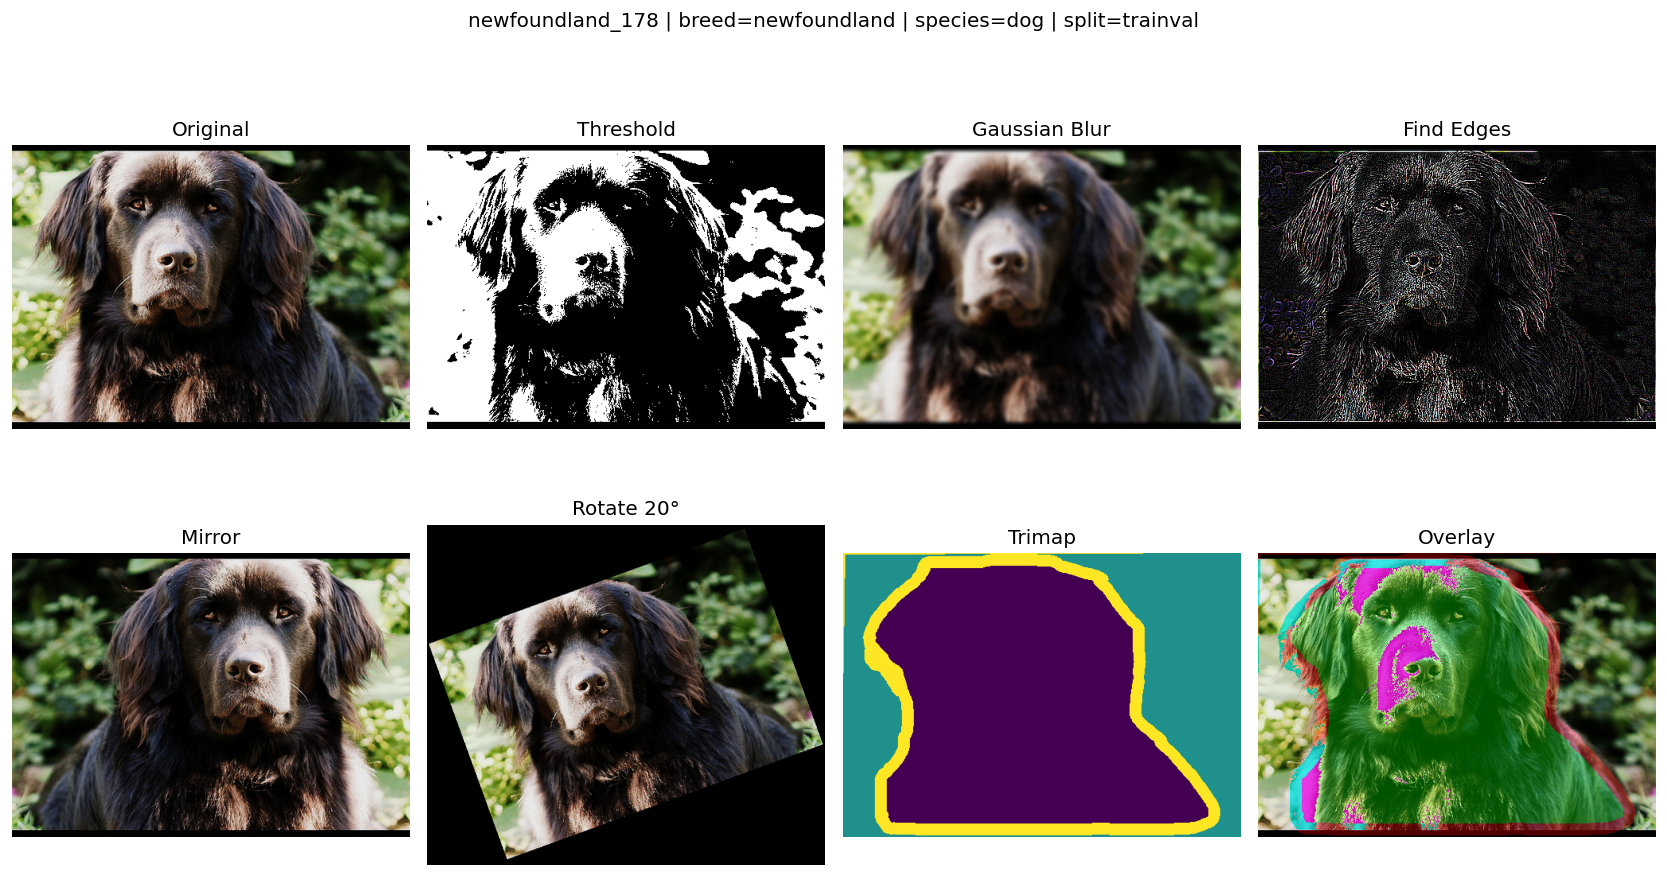

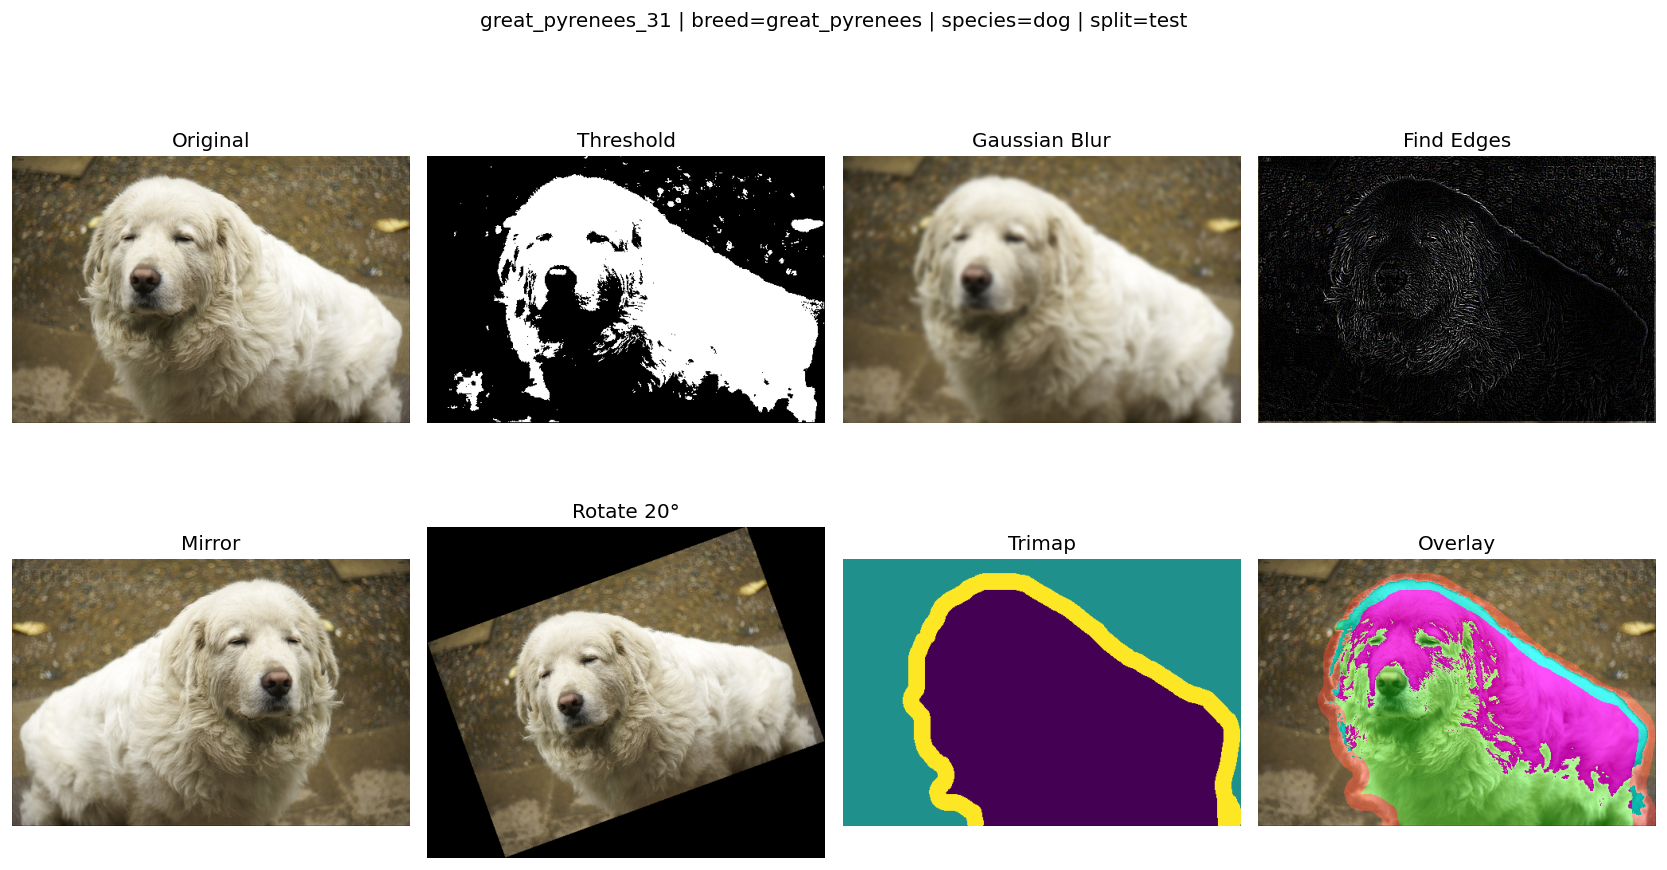

In [9]:
#EDA
import matplotlib.pyplot as plt
from PIL import ImageFilter, ImageOps

plt.rcParams["figure.dpi"] = 120

def preprocess_resize_normalize(img: Image.Image, size=(224, 224)) -> np.ndarray:
    img2 = img.resize(size, Image.BILINEAR)
    return np.asarray(img2).astype(np.float32) / 255.0

def thresholding_demo(img: Image.Image) -> np.ndarray:
    arr = np.array(img)
    gray = (0.299*arr[...,0] + 0.587*arr[...,1] + 0.114*arr[...,2]).astype(np.uint8)
    th = (gray > gray.mean()).astype(np.uint8) * 255
    return th

def filters_demo(img: Image.Image):
    blurred = img.filter(ImageFilter.GaussianBlur(radius=2))
    edges = img.filter(ImageFilter.FIND_EDGES)
    return blurred, edges

def transforms_demo(img: Image.Image):
    flipped = ImageOps.mirror(img)
    rotated = img.rotate(20, expand=True)
    return flipped, rotated

def load_trimap(trimap_path: str) -> np.ndarray:
    return np.array(Image.open(trimap_path))

def overlay_mask(img: Image.Image, trimap: np.ndarray) -> Image.Image:
    arr = np.array(img).copy()
    pet = (trimap == 1)
    unk = (trimap == 3)
    arr[..., 1] = np.clip(arr[..., 1] + pet.astype(np.uint8) * 80, 0, 255)
    arr[..., 0] = np.clip(arr[..., 0] + unk.astype(np.uint8) * 80, 0, 255)
    return Image.fromarray(arr)

def show_processing_examples(df: pd.DataFrame, n=3, seed=42):
    rows = df[df["img_exists"] & df["trimap_exists"]].sample(n, random_state=seed)
    for _, r in rows.iterrows():
        img = safe_open_image(r["img_path"])
        tri = load_trimap(r["trimap_path"])

        th = thresholding_demo(img)
        blurred, edges = filters_demo(img)
        flipped, rotated = transforms_demo(img)
        over = overlay_mask(img, tri)

        plt.figure(figsize=(14, 8))
        plt.suptitle(f'{r["image_name"]} | breed={r["breed_name"]} | species={r["species_name"]} | split={r["split"]}')

        ax = plt.subplot(2, 4, 1); ax.imshow(img); ax.set_title("Original"); ax.axis("off")
        ax = plt.subplot(2, 4, 2); ax.imshow(th, cmap="gray"); ax.set_title("Threshold"); ax.axis("off")
        ax = plt.subplot(2, 4, 3); ax.imshow(blurred); ax.set_title("Gaussian Blur"); ax.axis("off")
        ax = plt.subplot(2, 4, 4); ax.imshow(edges); ax.set_title("Find Edges"); ax.axis("off")

        ax = plt.subplot(2, 4, 5); ax.imshow(flipped); ax.set_title("Mirror"); ax.axis("off")
        ax = plt.subplot(2, 4, 6); ax.imshow(rotated); ax.set_title("Rotate 20°"); ax.axis("off")
        ax = plt.subplot(2, 4, 7); ax.imshow(tri, cmap="viridis"); ax.set_title("Trimap"); ax.axis("off")
        ax = plt.subplot(2, 4, 8); ax.imshow(over); ax.set_title("Overlay"); ax.axis("off")

        plt.tight_layout()
        plt.show()

show_processing_examples(eda_df, n=3)


In [10]:
breed_counts = eda_df["breed_name"].value_counts()
print("Breeds:", len(breed_counts))
print("max/min:", breed_counts.max(), "/", breed_counts.min())
print("imbalance ratio:", round(breed_counts.max()/breed_counts.min(), 2))

Breeds: 37
max/min: 200 / 184
imbalance ratio: 1.09


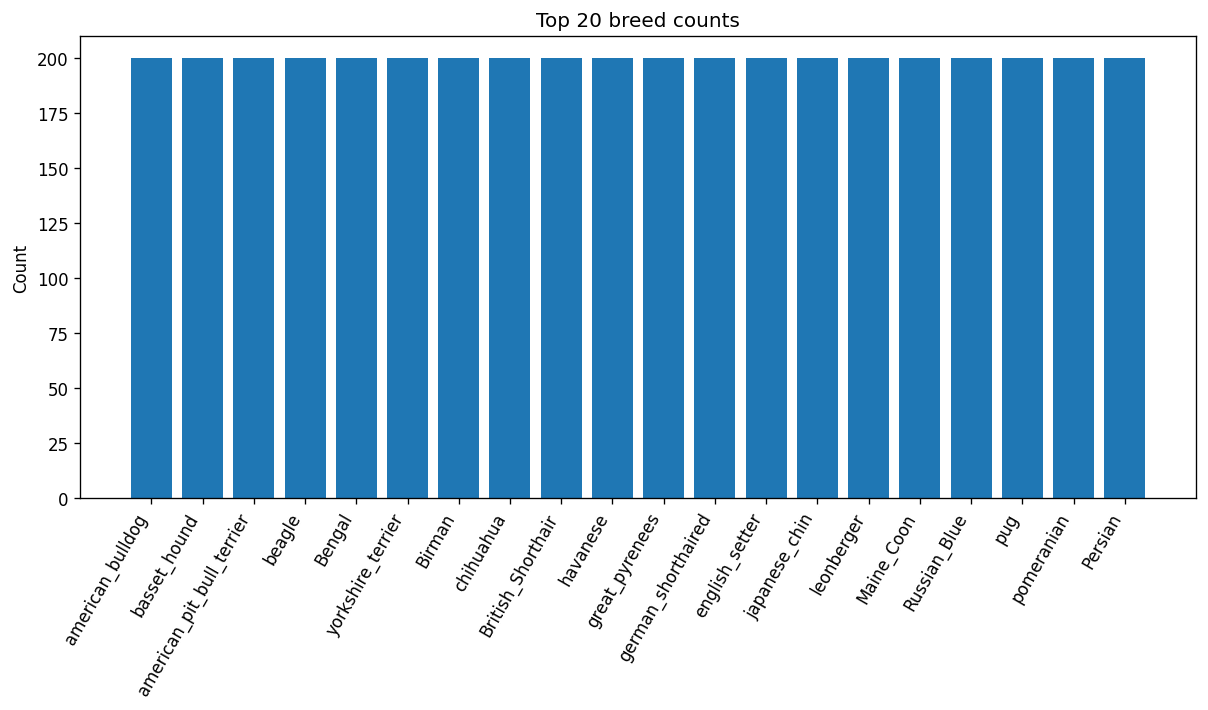

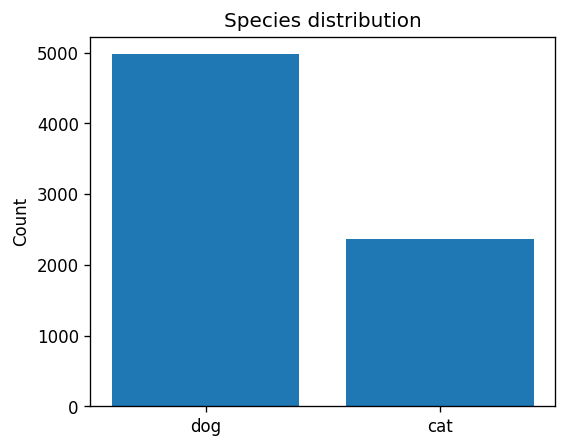

In [11]:

def plot_topk_breeds(df: pd.DataFrame, topk=20):
    counts = df["breed_name"].value_counts().head(topk)
    plt.figure(figsize=(12,5))
    plt.bar(counts.index, counts.values)
    plt.xticks(rotation=60, ha="right")
    plt.title(f"Top {topk} breed counts")
    plt.ylabel("Count")
    plt.show()

plot_topk_breeds(eda_df, topk=20)

plt.figure(figsize=(5,4))
sp = eda_df["species_name"].value_counts()
plt.bar(sp.index, sp.values)
plt.title("Species distribution")
plt.ylabel("Count")
plt.show()

In [12]:
dist = (
    master_df.groupby(["split","breed_name"])
    .size()
    .reset_index(name="count")
)
dist["prop"] = dist.groupby("split")["count"].transform(lambda s: s/s.sum())

dist_pivot = dist.pivot(index="breed_name", columns="split", values="prop").fillna(0)
dist_pivot["abs_diff"] = (dist_pivot["trainval"] - dist_pivot["test"]).abs()

print(dist_pivot.sort_values("abs_diff", ascending=False).head(10))

split                           test  trainval  abs_diff
breed_name                                              
staffordshire_bull_terrier  0.024257  0.027174  0.002917
Bombay                      0.023985  0.026087  0.002102
english_cocker_spaniel      0.027255  0.026087  0.001168
newfoundland                0.027255  0.026087  0.001168
Egyptian_Mau                0.026438  0.025272  0.001166
Abyssinian                  0.026710  0.027174  0.000464
Siamese                     0.027255  0.026902  0.000353
keeshond                    0.026983  0.027174  0.000191
scottish_terrier            0.026983  0.027174  0.000191
boxer                       0.026983  0.027174  0.000191


In [13]:
needed = ["pet_area_ratio","unknown_ratio","brightness","edge_strength"]
print("Missing cols in eda_df:", [c for c in needed if c not in eda_df.columns])

Missing cols in eda_df: []


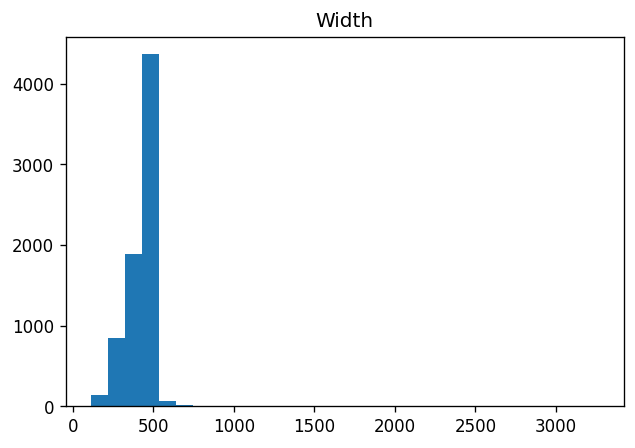

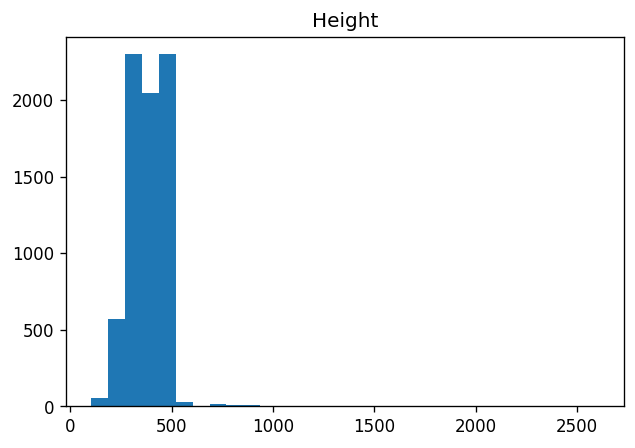

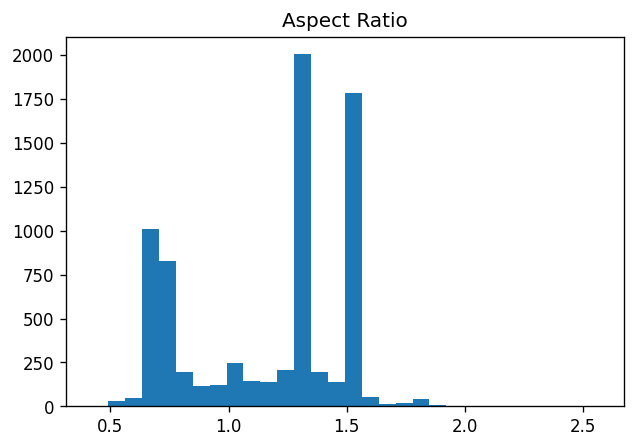

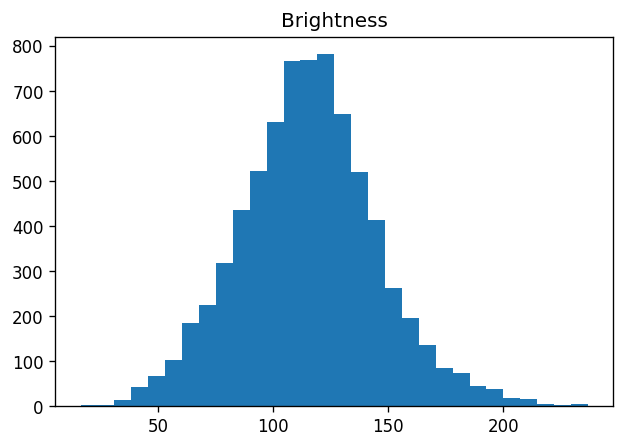

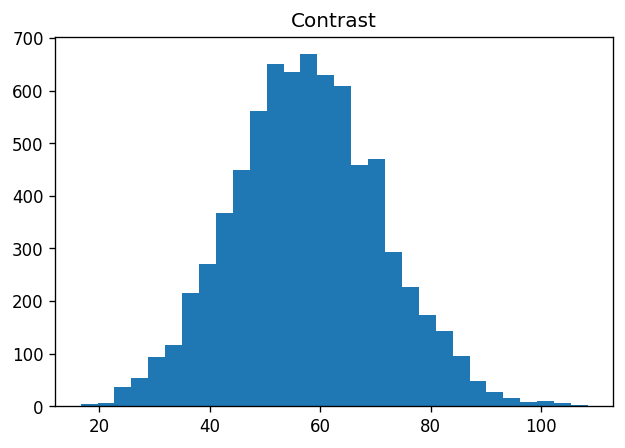

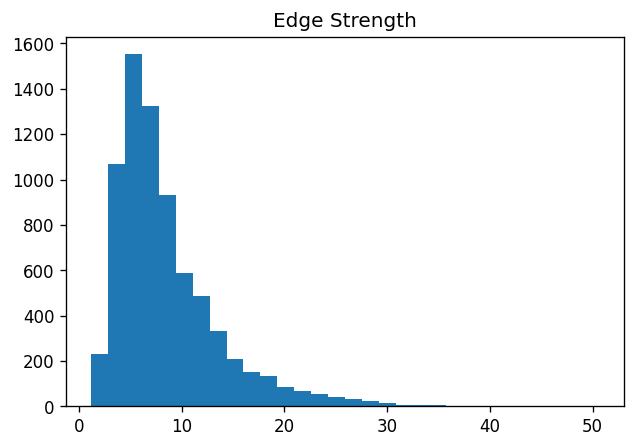

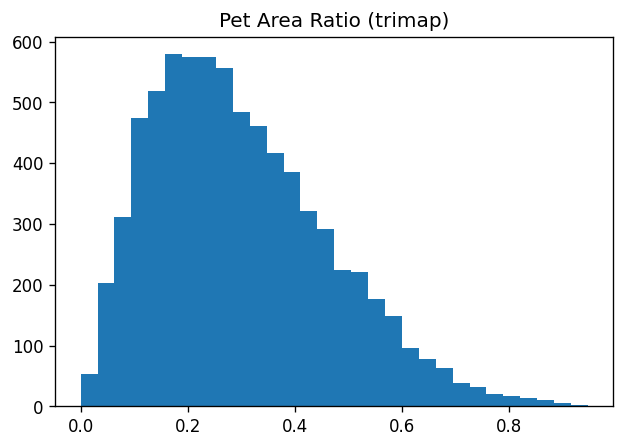

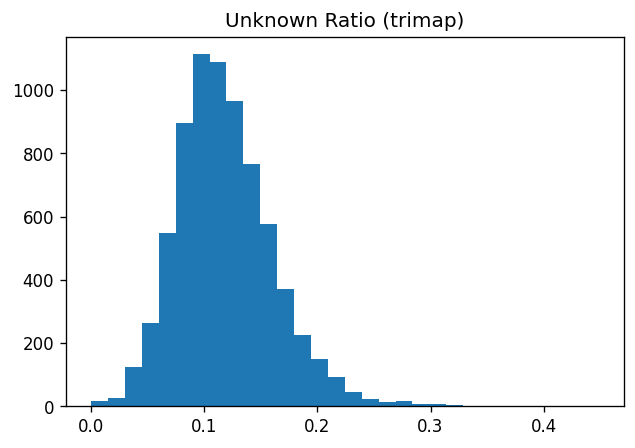

In [14]:
def hist_plot(series, title, bins=30):
    s = series.dropna()
    plt.figure(figsize=(6,4))
    plt.hist(s, bins=bins)
    plt.title(title)
    plt.show()

for col, title in [
    ("width","Width"), ("height","Height"), ("aspect_ratio","Aspect Ratio"),
    ("brightness","Brightness"), ("contrast","Contrast"), ("edge_strength","Edge Strength"),
    ("pet_area_ratio","Pet Area Ratio (trimap)"), ("unknown_ratio","Unknown Ratio (trimap)")
]:
    hist_plot(eda_df[col], title)

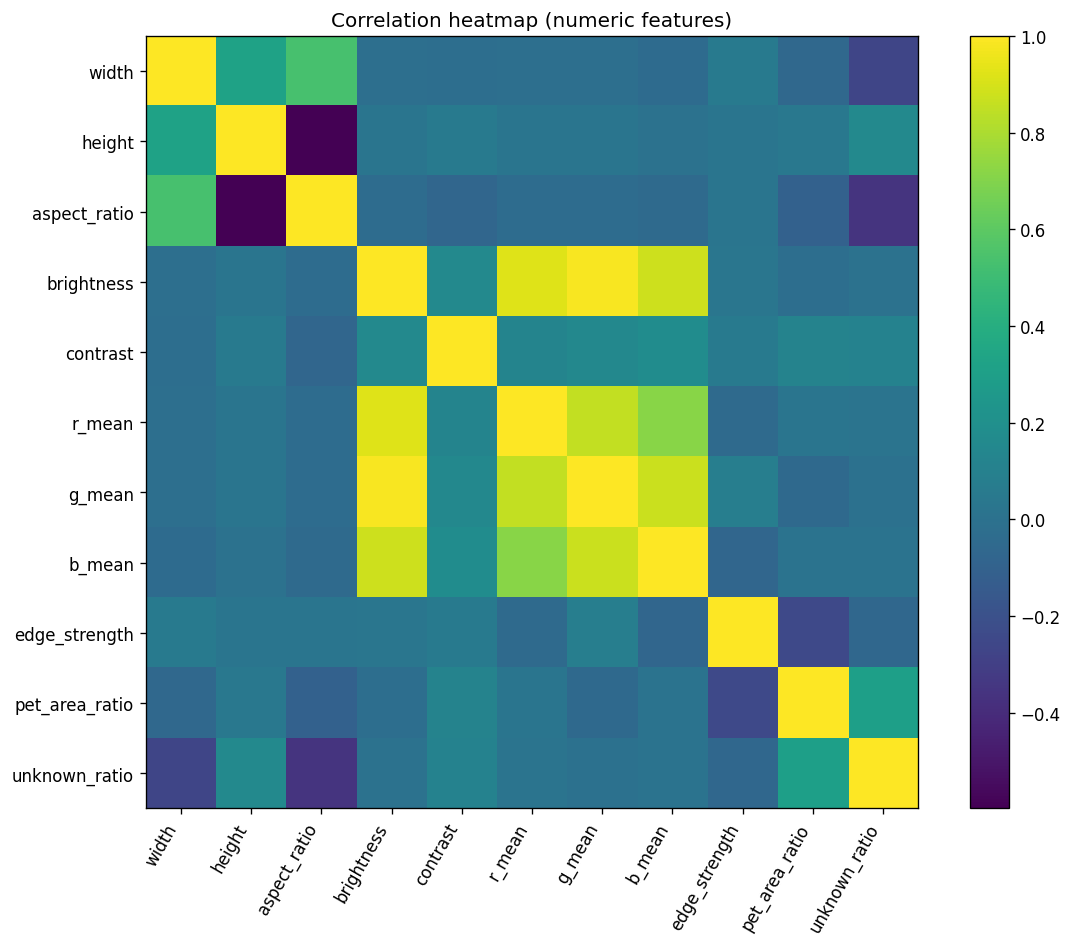

In [15]:
num_cols = [
    "width","height","aspect_ratio","brightness","contrast",
    "r_mean","g_mean","b_mean","edge_strength",
    "pet_area_ratio","unknown_ratio"
]
corr = eda_df[num_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, interpolation="nearest")
plt.title("Correlation heatmap (numeric features)")
plt.xticks(range(len(num_cols)), num_cols, rotation=60, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.tight_layout()
plt.show()

Brightness outliers: 123 low/high: 39.470100402831996 190.3081741333008


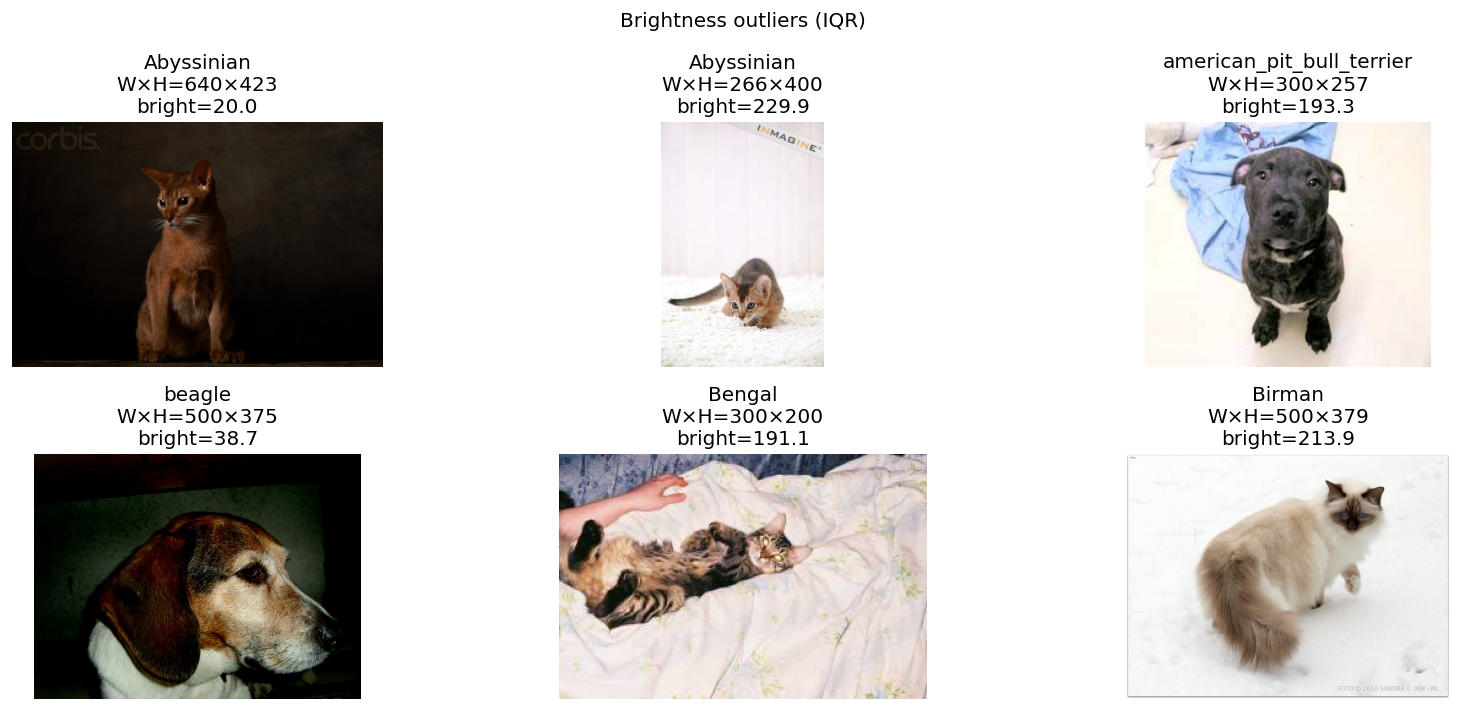

In [16]:
def find_outliers_iqr(df: pd.DataFrame, col: str):
    s = df[col].dropna()
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    out_idx = df[(df[col] < low) | (df[col] > high)].index
    return low, high, out_idx

def show_outlier_images(df: pd.DataFrame, idx_list, title, max_n=6):
    idx_list = list(idx_list)[:max_n]
    plt.figure(figsize=(14, 6))
    plt.suptitle(title)
    for i, idx in enumerate(idx_list):
        r = df.loc[idx]
        img = safe_open_image(r["img_path"])
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'{r["breed_name"]}\nW×H={r["width"]}×{r["height"]}\nbright={r["brightness"]:.1f}')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

low, high, out_idx = find_outliers_iqr(eda_df, "brightness")
print("Brightness outliers:", len(out_idx), "low/high:", low, high)
show_outlier_images(eda_df, out_idx, "Brightness outliers (IQR)", max_n=6)

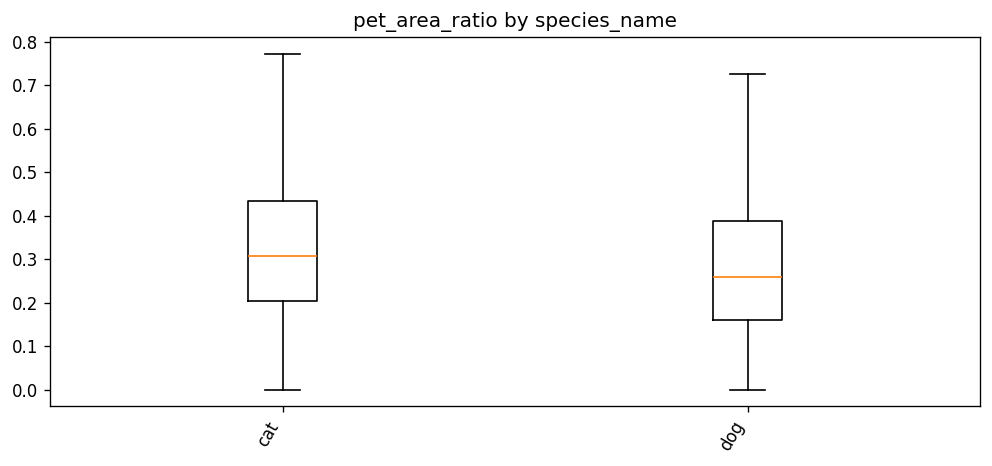

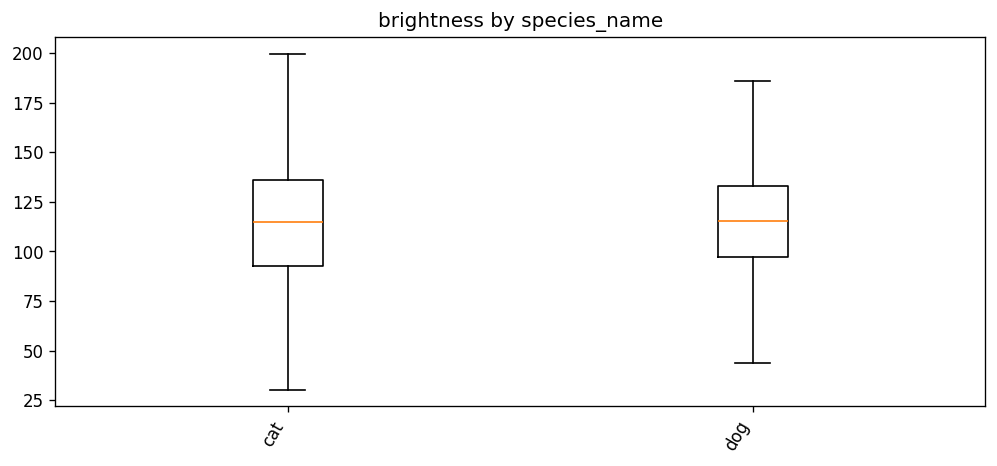

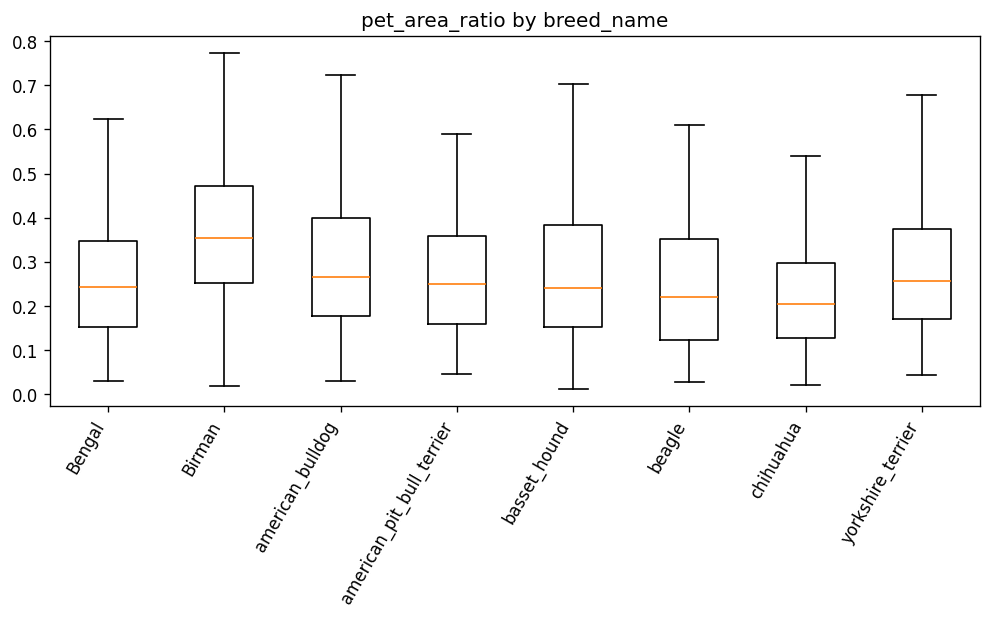

In [17]:
def boxplot_by_group(df, feature, group_col, topk=None):
    for c in [feature, group_col]:
        if c not in df.columns:
            raise KeyError(f"Column '{c}' not found. Available columns include: {df.columns.tolist()[:30]}")

    d = df.dropna(subset=[feature, group_col]).copy()
    if topk and group_col=="breed_name":
        top = d[group_col].value_counts().head(topk).index
        d = d[d[group_col].isin(top)]
    groups = [g[feature].values for _, g in d.groupby(group_col)]
    labels = list(d.groupby(group_col).groups.keys())
    plt.figure(figsize=(10,4))
    plt.boxplot(groups, tick_labels=labels, showfliers=False)
    plt.xticks(rotation=60, ha="right")
    plt.title(f"{feature} by {group_col}")
    plt.show()

boxplot_by_group(use_df, "pet_area_ratio", "species_name")
boxplot_by_group(use_df, "brightness", "species_name")
boxplot_by_group(use_df, "pet_area_ratio", "breed_name", topk=8)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

feature_cols = [
    "width","height","aspect_ratio","brightness","contrast",
    "r_mean","g_mean","b_mean","edge_strength",
    "pet_area_ratio","unknown_ratio"
]

use_df = eda_df[eda_df["img_exists"] & eda_df["trimap_exists"]].copy()
use_df = use_df.dropna(subset=["breed_name"])  # label 必须有

X_train = use_df.loc[use_df["split"]=="trainval", feature_cols]
y_train = use_df.loc[use_df["split"]=="trainval", "breed_name"]

X_test  = use_df.loc[use_df["split"]=="test", feature_cols]
y_test  = use_df.loc[use_df["split"]=="test", "breed_name"]

# 缺失值填充（稳）
imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(X_train)
X_test_imp  = imp.transform(X_test)

rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
rf.fit(X_train_imp, y_train)

pred_train = rf.predict(X_train_imp)
pred_test  = rf.predict(X_test_imp)

print("Baseline RandomForest")
print("Train accuracy:", round(accuracy_score(y_train, pred_train), 4))
print("Test  accuracy:", round(accuracy_score(y_test, pred_test), 4))

Baseline RandomForest
Train accuracy: 1.0
Test  accuracy: 0.0946


In [20]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split

# -----------------------------
# 0) 取 trainval / test
# -----------------------------
trainval_df = use_df[use_df["split"] == "trainval"].reset_index(drop=True)
test_df     = use_df[use_df["split"] == "test"].reset_index(drop=True)

# -----------------------------
# 1) Label encoding（只基于 trainval）
# -----------------------------
classes = sorted(trainval_df["breed_name"].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

# -----------------------------
# 2) train/val split（分层抽样）
#    val 比例你可以改：0.2 = 20%
# -----------------------------
train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.2,
    random_state=42,
    stratify=trainval_df["breed_name"]
)
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("train size:", len(train_df), "val size:", len(val_df), "test size:", len(test_df))

# -----------------------------
# 3) Transforms（ImageNet Normalize 必须有）
# -----------------------------
weights = models.ResNet18_Weights.DEFAULT
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_tfms = val_tfms  # test 跟 val 一样，不要增强

# -----------------------------
# 4) Dataset / Dataloader
# -----------------------------
class PetDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img = Image.open(r["img_path"]).convert("RGB")
        x = self.tfms(img)
        y = class_to_idx[r["breed_name"]]
        return x, y

train_ds = PetDataset(train_df, train_tfms)
val_ds   = PetDataset(val_df,   val_tfms)
test_ds  = PetDataset(test_df,  test_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=0)

# -----------------------------
# 5) Device / Model
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

model = models.resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# -----------------------------
# 6) Eval function
# -----------------------------
def evaluate_acc(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return correct / total if total else 0

# -----------------------------
# 7) Train loop（只看 val，不看 test）
#    记录 best_val_acc，保存 best weights
# -----------------------------
EPOCHS = 8
best_val_acc = 0.0
best_state = None

for ep in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)

    train_acc = evaluate_acc(model, train_loader)
    val_acc   = evaluate_acc(model, val_loader)
    avg_loss  = running_loss / len(train_ds)

    # 保存 best（按 val_acc）
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {ep}/{EPOCHS} | loss={avg_loss:.4f} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")

# -----------------------------
# 8) 最后：加载 best，再评估一次 test
# -----------------------------
if best_state is not None:
    model.load_state_dict(best_state)

test_acc = evaluate_acc(model, test_loader)
print(f"\nBest val_acc={best_val_acc:.4f} | FINAL test_acc={test_acc:.4f}")

train size: 2944 val size: 736 test size: 3669
device: cpu
Epoch 1/8 | loss=1.8164 | train_acc=0.9096 | val_acc=0.8601
Epoch 2/8 | loss=0.5383 | train_acc=0.9664 | val_acc=0.8886
Epoch 3/8 | loss=0.2556 | train_acc=0.9898 | val_acc=0.9049
Epoch 4/8 | loss=0.1319 | train_acc=0.9966 | val_acc=0.9049
Epoch 5/8 | loss=0.0800 | train_acc=0.9976 | val_acc=0.9226
Epoch 6/8 | loss=0.0460 | train_acc=0.9990 | val_acc=0.9171
Epoch 7/8 | loss=0.0312 | train_acc=0.9997 | val_acc=0.9062
Epoch 8/8 | loss=0.0229 | train_acc=1.0000 | val_acc=0.9226

Best val_acc=0.9226 | FINAL test_acc=0.8803


In [21]:
df = eda_df
print("Columns:", df.columns.tolist())

# split 列情况
print("\nHas split column?", "split" in df.columns)
if "split" in df.columns:
    print("split value counts:\n", df["split"].value_counts(dropna=False).head(20))

# target 列情况
print("\nHas target column?", "target" in df.columns)
if "target" in df.columns:
    print("target null rate:", df["target"].isna().mean())

# 特征列缺失情况
candidate_features = [
    "width","height","aspect_ratio",
    "brightness","contrast",
    "r_mean","g_mean","b_mean",
    "edge_strength",
    "frames_mean","frames_std","frames_p05","frames_p95",
    "binsa_mean","binsa_std","binsa_p05","binsa_p95",
]
feature_cols = [c for c in candidate_features if c in df.columns]
print("\nFeature cols found:", feature_cols)

if feature_cols:
    print("Any NaN rate per feature (top 10):\n",
          df[feature_cols].isna().mean().sort_values(ascending=False).head(10))

Columns: ['image_name', 'class_id', 'species_id', 'breed_id', 'split', 'img_path', 'trimap_path', 'xml_path', 'img_exists', 'trimap_exists', 'xml_exists', 'breed_name', 'species_name', 'width', 'height', 'aspect_ratio', 'brightness', 'contrast', 'r_mean', 'g_mean', 'b_mean', 'edge_strength', 'pet_area_ratio', 'unknown_ratio']

Has split column? True
split value counts:
 split
trainval    3680
test        3669
Name: count, dtype: int64

Has target column? False

Feature cols found: ['width', 'height', 'aspect_ratio', 'brightness', 'contrast', 'r_mean', 'g_mean', 'b_mean', 'edge_strength']
Any NaN rate per feature (top 10):
 width            0.0
height           0.0
aspect_ratio     0.0
brightness       0.0
contrast         0.0
r_mean           0.0
g_mean           0.0
b_mean           0.0
edge_strength    0.0
dtype: float64
